In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import os
import time
from pathlib import Path
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import math

In [11]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes

num_train = metadata.splits['train'].num_examples * 0.8
num_validation = metadata.splits['train'].num_examples * 0.1
num_test = metadata.splits['train'].num_examples * 0.1

print(num_classes)
print(num_train)
print(num_validation)
print(num_test)

# augment the data
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# normalize the data


120
9600.0
1200.0
1200.0


In [14]:
def random_shift(image, max_shift=20):
    # Pad the image by max_shift pixels on all sides
    padded_image = tf.image.pad_to_bounding_box(image, max_shift, max_shift, 
                                                tf.shape(image)[0] + 2 * max_shift, 
                                                tf.shape(image)[1] + 2 * max_shift)
    
    # Randomly crop back to the original size to simulate a shift
    cropped_image = tf.image.random_crop(padded_image, size=[tf.shape(image)[0], tf.shape(image)[1], 3])
    
    return cropped_image

def preprocess_augment_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    image = random_shift(image, max_shift=20)
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    return image, label

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

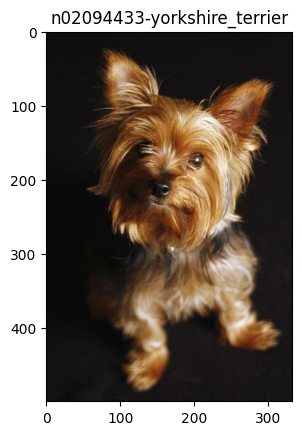

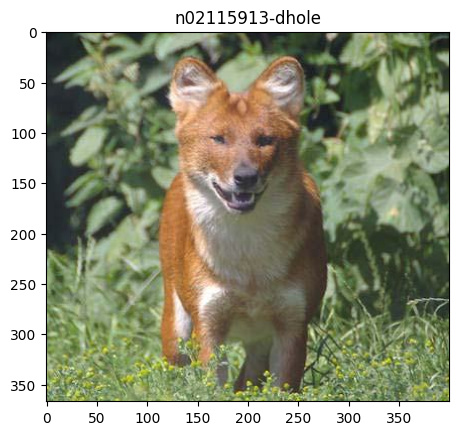

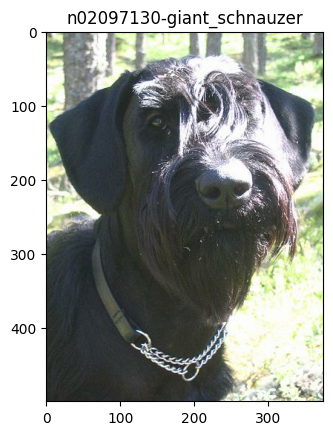

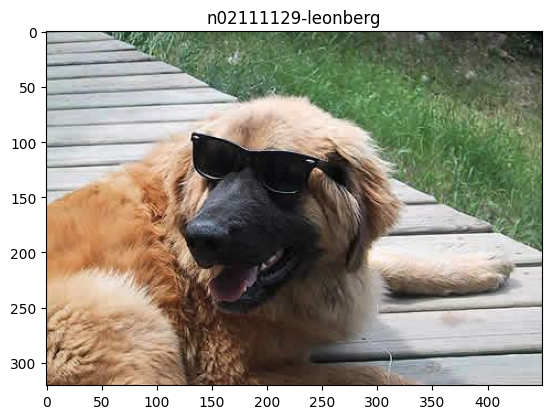

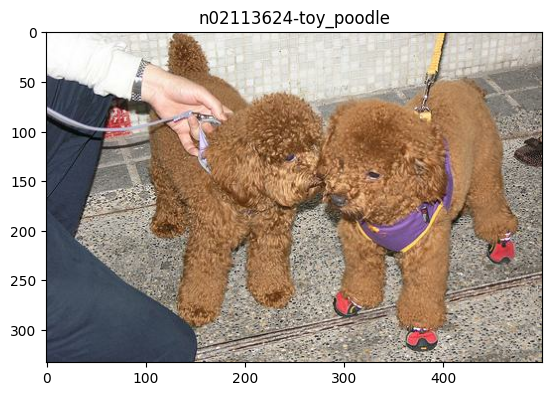

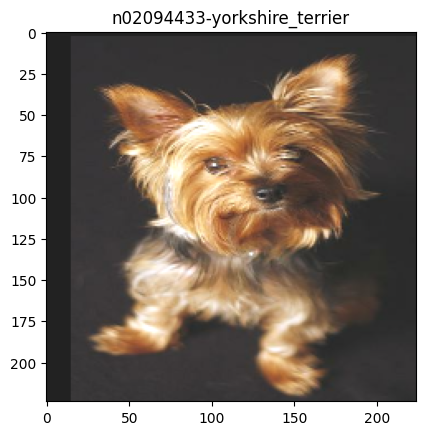

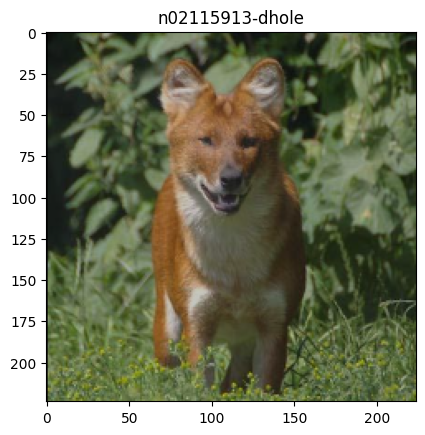

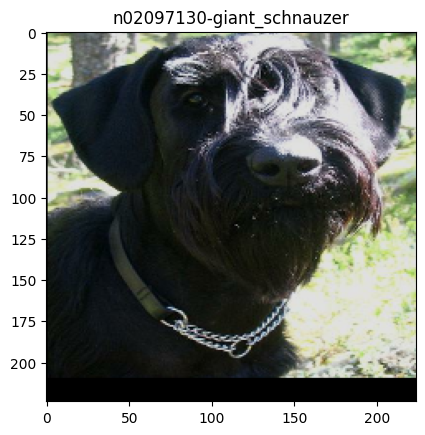

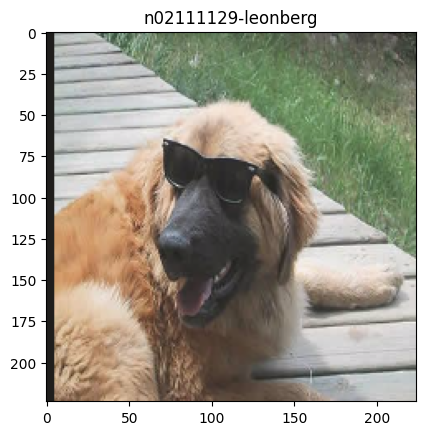

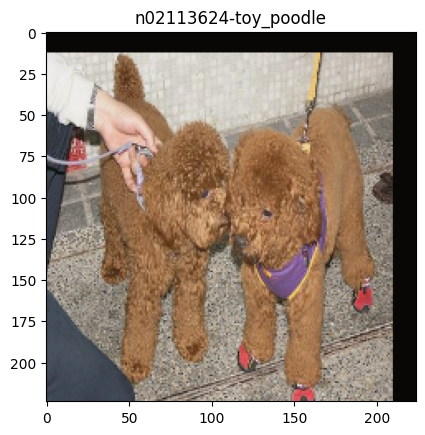

In [15]:
# show some dog images

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

for image, label in raw_train.take(5):
    image, label = preprocess_augment_image(image, label)
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train = raw_train.map(preprocess_augment_image).shuffle(1000).batch(64).prefetch(AUTOTUNE)
validation = raw_validation.map(preprocess_image).batch(64).prefetch(AUTOTUNE)
test = raw_test.map(preprocess_image).batch(64).prefetch(AUTOTUNE)

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

random_rotation = keras.layers.RandomRotation(factor=0.15)
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = random_rotation(inputs)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
# model.evaluate(test)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_10              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,975,416 (11.35 MB)

 Trainable params: 717,432 (2.74 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
model.fit(train, epochs=20, validation_data=validation, callbacks=[early_stopping_cb])
model.save('mobileNetV2_frozen_20epoch_early_stop.keras')
model.evaluate(test)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 536ms/step - accuracy: 0.1521 - loss: 3.9709 - val_accuracy: 0.6658 - val_loss: 1.2095
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 579ms/step - accuracy: 0.4612 - loss: 1.9893 - val_accuracy: 0.7117 - val_loss: 0.9646
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 595ms/step - accuracy: 0.5374 - loss: 1.6746 - val_accuracy: 0.7275 - val_loss: 0.8813
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 769ms/step - accuracy: 0.5693 - loss: 1.5662 - val_accuracy: 0.7183 - val_loss: 0.8584
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 906ms/step - accuracy: 0.5903 - loss: 1.4683 - val_accuracy: 0.7167 - val_loss: 0.8351
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 691ms/step - accuracy: 0.5947 - loss: 1.4068 - val_accuracy: 0.7250 - val_loss: 0.8402
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 735ms/step - accuracy: 0.6061 - loss: 1.3873 - val_accuracy: 0.7575 - val_loss: 0.7980
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 976ms/step - accuracy: 0.6223 - lo

[0.8196065425872803, 0.7266666889190674]

In [25]:
model = keras.models.load_model('mobileNetV2_frozen_20epoch_early_stop.keras')
model.evaluate(test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7527 - loss: 0.7843


[0.8716655373573303, 0.7266666889190674]

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
model.fit(train, epochs=20, validation_data=validation, callbacks=[early_stopping_cb, lr_scheduler])
model.save('mobileNetV2_frozen_20epoch_early_stop.keras')
model.evaluate(test)